In [1]:
# Copyright 2020 Bengier Ülgen Kılıç
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies
# of the Software, and to permit persons to whom the Software is furnished to do
# so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all 
#copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

In [1]:
import numpy as np
import networkx as nx
import random
import os
import csv
from glob import glob
from matplotlib import pyplot as plt
from read_roi import read_roi_zip


try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

##    "KMCalcium is a very limited python package that is open to further development for analyzing Kuramoto Model that is initialized according to the Calcium traces obtained from two-photon microscopy. Following tuttorial is a quick pipeline that walks you through the package and analysis in the associated report."

##    "KMCalcium is a python package that does the following"

###    '1. running the kuramoto model on a network of coupled oscillators
###    '2. computing the phase coherence and edgewise synchrony of the system per iteration and graphing it'

In [3]:
class kuramoto_model_network: ##Network Object with oscillator objects as nodes

    
    ####################################################################
    ##  we can think of this class as the environment of our model    ##
    ####################################################################
    
    def __init__(self,time, oscillators):
        
        ##initialize a network with a time stamp and oscillators
        
        ##attributes of the kuramato model network:
        
        ## time, oscillators, and size of the network
        
        self.time = int(time)
        self.nodes = oscillators
        self.size = len(oscillators)
    
        ####################################################
        ##some built-in funcitons to avoid further confusion
        ####################################################
    def __eq__(self,other):
        return self.time==other.time
    
    def __hash__(self):
        return hash((self.time,self.oscillators))
    
    def __str__(self):
        return "Temporal Network Object with time step:"+str(self.time)
    
        #####################################################
        ## Functions to make explorotions on the network
        #####################################################    
    
    def make_network(self, graph_type = 'complete', plot=True, **kwargs):
        
        ####
        ###
        ## we use networkx to create a network with each node has an attribute of 'theta' as the amount of calcium
        ## and 'omega' uniform random distribution
        ###
        
        ## if plot=True: plots the network
        
        ## graph_type: indicates the type of the graph to be initialized among 'complete', 'random', 'barabasi' and
        ##             'configuration'
        
        ## if graph_type = ' random' or 'barabasi', additional argument 'prob=' is needed
        
        ## if graph type = 'configuration', additional argument 'degree_sequence=' is needed
        ####
        
        if graph_type == 'complete': G = nx.generators.classic.complete_graph(self.size)
        elif graph_type == 'random': G = nx.gnp_random_graph(self.size, kwargs['prob'])
        elif graph_type == 'barabasi': G = nx.barabasi_albert_graph(self.size,kwargs['prob'])
        elif graph_type == 'configuration': G = nx.configuration_model(deg_sequence= kwargs['degree_sequence'])
        
        for i in range(int(self.size)):
            G.nodes[i]['theta'] = 2 * np.pi * self.nodes[i].state
            G.nodes[i]['omega'] = self.nodes[i].angular_velocity
            
        if plot:
            nx.draw_spring(G, width=0.08,node_size=20)
            
        return(G)

        
    def update_nodes(self, G, Dt):
        
        ## function to run the simulation
        
        ## takes the network G and Dt as arguments where Dt is the time iteration
        
        
        for i in G.nodes:
            theta_i = G.nodes[i]['theta']
            G.nodes[i]['theta'] = theta_i + (G.nodes[i]['omega'] + self.nodes[i].coupling_strength * (sum([np.sin(G.nodes[j]['theta'] - theta_i) for j in G.neighbors(i)])/ G.degree(i))) * Dt
        self.time = self.time+1
    
    
    def r_of_t(self,G):
        
        ## function that computes the phase coherence at every iteration
        
        n = self.size
        sync=0
        for i in range(n):
            sync=sync+(complex(np.cos(G.nodes[i]['theta']),np.sin(G.nodes[i]['theta'])))
        synchrony=abs((1/n)*sync)
        return(synchrony)
    
    def r_link_of_t(self,G): 
        
        ### function that computes the coupling strength, edgewise synchrony, of individual
        ### rois wtr to the phase coherence over time
        
        ### Outputs[0]: the edgewise syncrony matrix
        ### Outputs[1]: global measur of synchrony r_link
        
        n=self.size                           
        C=np.zeros((n,n)) 
        k=0                  
        
        for i in range(n):                
            for j in range(len(list(G.neighbors(i)))):
                k=k+complex(np.cos(G.nodes[i]['theta']-G.nodes[j]['theta']),np.sin(G.nodes[i]['theta']-G.nodes[i]['theta']))
                C[j][i]=abs(k)
                C[i][j]=abs(k)
                
        S = C.sum(dtype='float')
        rlink = float(S/n*(n-1))
        
        return(C, rlink)
    
    
    def fraction_of_synced_nodes(self,G,time,dt):
        
        ##function that computes the fraction of synchronized node pairs after 'time' iteration
        
        ## G: network
        ## time: number of steps the system is going to be iterated
        ## dt: size of the steps the system is going to be iterated
        
        ##Returns: List of values of rlink of the system at each iteration
        
        rlink_over_time=[]
        for t in range(time):
            self.update_nodes(G,dt)
            l = self.r_link_of_t(G)[1]
            rlink_over_time.append(l)
        return(rlink_over_time)
    
    def phase_coherence(self,G,time,dt,plot=True, threshold=True, **kwargs):
        
        ## function that computes the phase coherence and graphs it after 'time' iteration
        
        ## G: network
        ## time: number of steps the system is going to be iterated
        ## dt: size of the steps the system is going to be iterated
        ## if plot=True: plots the phase coherence
        ## if threshold=True: a red bar shows up in the figure to indicate the threshold where the system is 'synchronous'
        ##               aditional argument 'value' between 0 and 1 is needed
        
        ## Returns: list of values of the phase coherences of the system at each time iteration
        
        if self.time != 0: return(print('Initialize the oscillators and network then try again' ))
        phase_coherence_over_time = []
        for t in range(time):
            self.update_nodes(G,dt)
            k = self.r_of_t(G)
            phase_coherence_over_time.append(k)
            
            
        if plot==True:
            
            
            thres = 0
            if threshold == True:
                for t,i in enumerate(phase_coherence_over_time):
                    if i > kwargs['value']: thres=t; break
                       
            fig,ax = plt.subplots(1,1,figsize=(8,8))
            x = np.linspace(0,1000,1000)
            ax.plot(phase_coherence_over_time)
            ax.set_title("r_{t} vs time",fontsize=20)
            ax.set_ylabel('phase_coherence',fontsize=15)
            ax.set_xlabel('time',fontsize=15)
            ax.tick_params(axis='both', which='major', labelsize=15)
            if not thres == 0:
                ax.axvline(thres,color='red')
                ax.text(thres, kwargs['value'] ,'%s'%thres, fontsize=15)
                
        self.time=0
        return(phase_coherence_over_time)
    

    
class kuramoto_oscillator:## main class of objects for the model
    
    
    ################################################################
    ## these are our agents in the model each having attributes of :
    
    
    ## omega(an internal frequency): One of the three options are available, 'uniform', 'normal','gamma'                                
    
    ## theta(state-calcium level): 'random' or float between 0 and 1
    
    ## alpha(coupling strength- edgewise synchrony computed from the data): float between 0 and 1
    
    ################################################################
    
    def __init__(self,omega, theta, alpha):
        
        if theta == 'random': self.state = 2 * np.pi * np.random.rand(1,1)
        else: self.state = 2 * np.pi * theta
                    
        if omega == 'uniform': self.angular_velocity = 1 + np.random.uniform(-0.05,0.05)
        elif omega == 'normal': self.angular_velocity = np.random.normal(1,0.05)
        elif omega == 'gamma': self.angular_velocity =  1 + random.choice((-1,+1)) * np.random.gamma(1,0.05) 
            
        self.coupling_strength = alpha
        
        #################################
        ##        built-ins            ##
        #################################
        
    def __eq__(self,other):
        return self.alpha == other.alpha and self.angular_velocity==other.angular_velocity
    
    def __hash__(self):
        return hash((self.state, self.angular_velocity))
    
    def __str__(self):
        return "Kuramato oscillator with instantaneous state"+str(self.state)+ "and internal frequency"+ str(self.angular_velocity)
    
    
    
#######################################################################################################################
############ Some functions for Sample intialization and data reading #################################################
#######################################################################################################################



def create_osc(N, omega, theta, alpha):
    
    ## handy function that creates the oscillators
    
    o=[]# list containing the oscillator objects
    
    for i in range(N): 
        o.append(kuramoto_oscillator(omega, theta , alpha))
        
    return(o)

def create_net(oscillators, type_graph, prob=bool, plot=bool, degree_sequence=bool):
    
    ### handy function that creates the networks
    
    M=kuramoto_model_network(0,oscillators) ## returns kuramato model network object

    N=kuramoto_model_network(0,oscillators).make_network(graph_type=type_graph,prob=False, plot=True)
    
    return(M,N)

def edgewise_synchronization(number_of_rois,name,data, time):
    
    ## function that computes the edgewise synchrony of the ROIS from the calcium dynamics
    
    n=number_of_rois                               
    C=np.zeros((n,n))
    
    for i in range(n):
        for j in range(i):
            k=0
            for t in range(int(time)):
                k=k+complex(np.cos(data['%s'%name][i][t]-data['%s'%name][j][t]),np.sin(data['%s'%name][i][t]-data['%s'%name][j][t]))
            C[j][i]=abs(k)/int(time)
            C[i][j]=abs(k)/int(time)
            
    return(C)

## Sample Initialization

### 1) Create *50* Kuramoto Oscillators with *unifrom* angular velocity distribution and a *random* initial state with coupling strength *1*.

In [4]:
oscillators = create_osc(50, 'uniform', 'random',1) 
###########
## N = number of oscillators

## omega = distribution of the internal frequencies of the oscillators across the network
##         can be 'uniform', 'normal' or 'gamma' 

## theta = initial state of the oscillators can only be 'random' or a number between 0 and 1 at this point

## alpha = between [0,1], coupling strength
###########

### 2) Create Networkx *complete* graphs and network objects

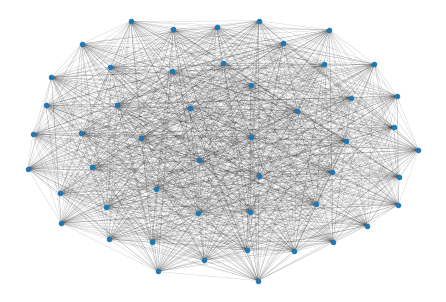

In [5]:
M,N=create_net(oscillators, 'complete', prob=False, plot= True, degree_sequence=False )
##############
## oscillators= oscillator objects

## graph_type= network topology to be created. can be 'complete', 'random', 'barabasi', 'configuration'

## prob = if 'random' or 'barabasi' selected, should be given between [0,1]

## degree_sequence= if 'configuration' is selected, should be given as a sequence of node degrees

## plot= plots the network
##############

### 3) Plot phase coherence over time *1000* steps with step size *0.01*

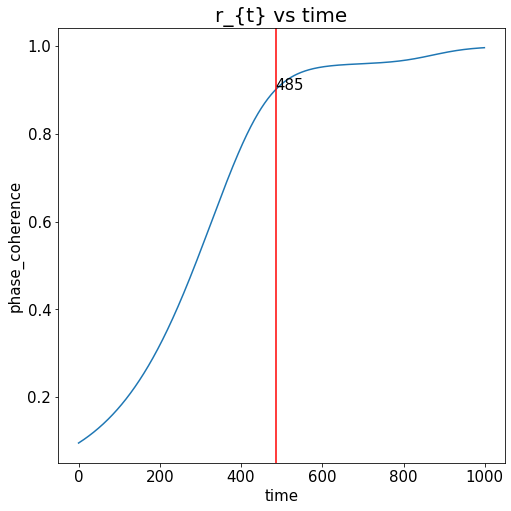

In [6]:
phase=M.phase_coherence(N,1000,0.01,plot=True, threshold=True, value=0.9)
## N: Network objects#
## time = 1000
## dt = 0.01
## plot = True
## thresholding value = 0.9

# Analysis


### You need to change the path to continue with your analysis. I saved necessary file into the master file to run this tuttorial, so you can just import them if you want to see how the pipeline works

In [3]:
#path = 'C:/Users/ulgen/OneDrive/Masaüstü/KMCalcium/traces_rois/'

## 4) Reading the calcium traces and rois then computing the averages that is going to be initial state of each oscillator.

## files need to be on a specific naming convention as m_id_session_#.csv for cleaned traces and m_id_session_epoch.zip for roi files

In [4]:
#data = {}
#initial_state = {}
#base_names = []
#subject_names = []
#test_names = []
#os.chdir(path)
#for file in glob("*.csv"):
    #base = os.path.splitext(file)[0]
    #subject = base.split('_')[0] + '_' + base.split('_')[1] + '_' + base.split('_')[2] + '_' + base.split('_')[3]
    #base_names.append(base)
    #if subject not in subject_names: subject_names.append(subject)
    #print(base)
    #test_names.append(base)
    #roi = read_roi_zip(glob(path)[0] + base + '.zip')
    #trace = open(path + file, "r")
    #reader_trace = csv.reader(trace)
    #traces = np.zeros((len(roi),8000))
    #average = []
    #for i,line in enumerate(reader_trace):
        #total = 0
        #for j in range(len(line)):
            #traces[i][j] = 2 * np.pi * float(line[j]) ## traces are scaled by 2 pi
            #total = total + traces[i][j]
        #avg = total/len(line)
        #average.append(avg)
    #data[base] = traces
    #initial_state[base] = average

m_1102_session_1_baseline
m_1102_session_1_early
m_1102_session_1_pre
m_1183_session_1_baseline
m_1183_session_1_early
m_1183_session_1_pre
m_1309_session_1_baseline
m_1309_session_1_early
m_1309_session_1_pre
m_18_session_1_baseline
m_18_session_1_early
m_18_session_1_pre
m_963_session_3_baseline
m_963_session_3_early
m_963_session_3_pre


In [3]:
#with open('data.p', 'rb') as fp:
    #data = pickle.load(fp)

## 5) Computing the edgewise synchrony of the neurons for initialization
##  -- takes kinda long time, you can directly import the files in the next cell

In [21]:
#alpha={}
#coupling= {}
#for i, name in enumerate(test_names):
    #print(name)
    #coupling[name] = edgewise_synchronization(data[name].shape[0],name,data,8000)
    #weight=0
    #all_weights=[]
    #for j in range(coupling[name].shape[0]):
        #weight = sum([coupling[name][j][k] for k in range(coupling[name].shape[1])])
        #avg = weight/coupling[name].shape[0]
        #all_weights.append(avg)
    #alpha[name] = all_weights

m_1102_session_1_baseline
m_1102_session_1_early
m_1102_session_1_pre
m_1183_session_1_baseline
m_1183_session_1_early
m_1183_session_1_pre
m_1309_session_1_baseline
m_1309_session_1_early
m_1309_session_1_pre
m_18_session_1_baseline
m_18_session_1_early
m_18_session_1_pre
m_963_session_3_baseline
m_963_session_3_early
m_963_session_3_pre


In [7]:
with open('coupling.p', 'rb') as fp:
    coupling = pickle.load(fp)

with open('alpha.p', 'rb') as fp:
    alpha = pickle.load(fp)
    
with open('test_names.p', 'rb') as fp:
    test_names = pickle.load(fp)
    
with open('initial_state.p', 'rb') as fp:
    initial_state = pickle.load(fp)

## 6) Compute degree distributions for the configuration network: scale parameter=50

In [8]:
degree_distributions={}
for j, name in enumerate(test_names):
    l = []
    for i in range(len(alpha[name])):
        k = int(round(alpha[name][i]*50))
        l.append(k)
    if not sum([x for x in l]) % 2 == 0: l[0]=l[0]+1
    degree_distributions[name] = l

## 7) Initialize networks and oscillators, feel free to play with the variables

In [9]:
oscillators = {}
networks = {}
kuramoto_networks = {}
for i, name in enumerate(test_names):
    O = []
    for j in range(len(initial_state[name])):
        O.append(kuramoto_oscillator('uniform',initial_state[name][j],alpha[name][j]))
        ## oscillators with unifrom distribution, state=average calcium, coupling strength=edgewise synchrony
    oscillators[name] = O
    N = kuramoto_model_network(0,oscillators[name]).make_network(graph_type='configuration', plot=False, degree_sequence=degree_distributions[name])
    ## network type=configuration
    networks[name] = N
    M = kuramoto_model_network(0,oscillators[name])
    kuramoto_networks[name] = M 

### 7a) Duration of the simulation, iteration=1000 for this one, thresh=0.8(just for plotting purposes)

In [10]:
phase_coherences = {}
iteration=1000
thresh=0.8
thresholds=[]
for i, name in enumerate(test_names):
    phase=kuramoto_networks[name].phase_coherence(networks[name],iteration,0.01,plot=False, threshold=True, value=0.9)
    phase_coherences[name] = phase
    threshold=0
    for t,i in enumerate(phase_coherences[name]):
        if i>thresh: threshold = t; break
    thresholds.append(threshold)

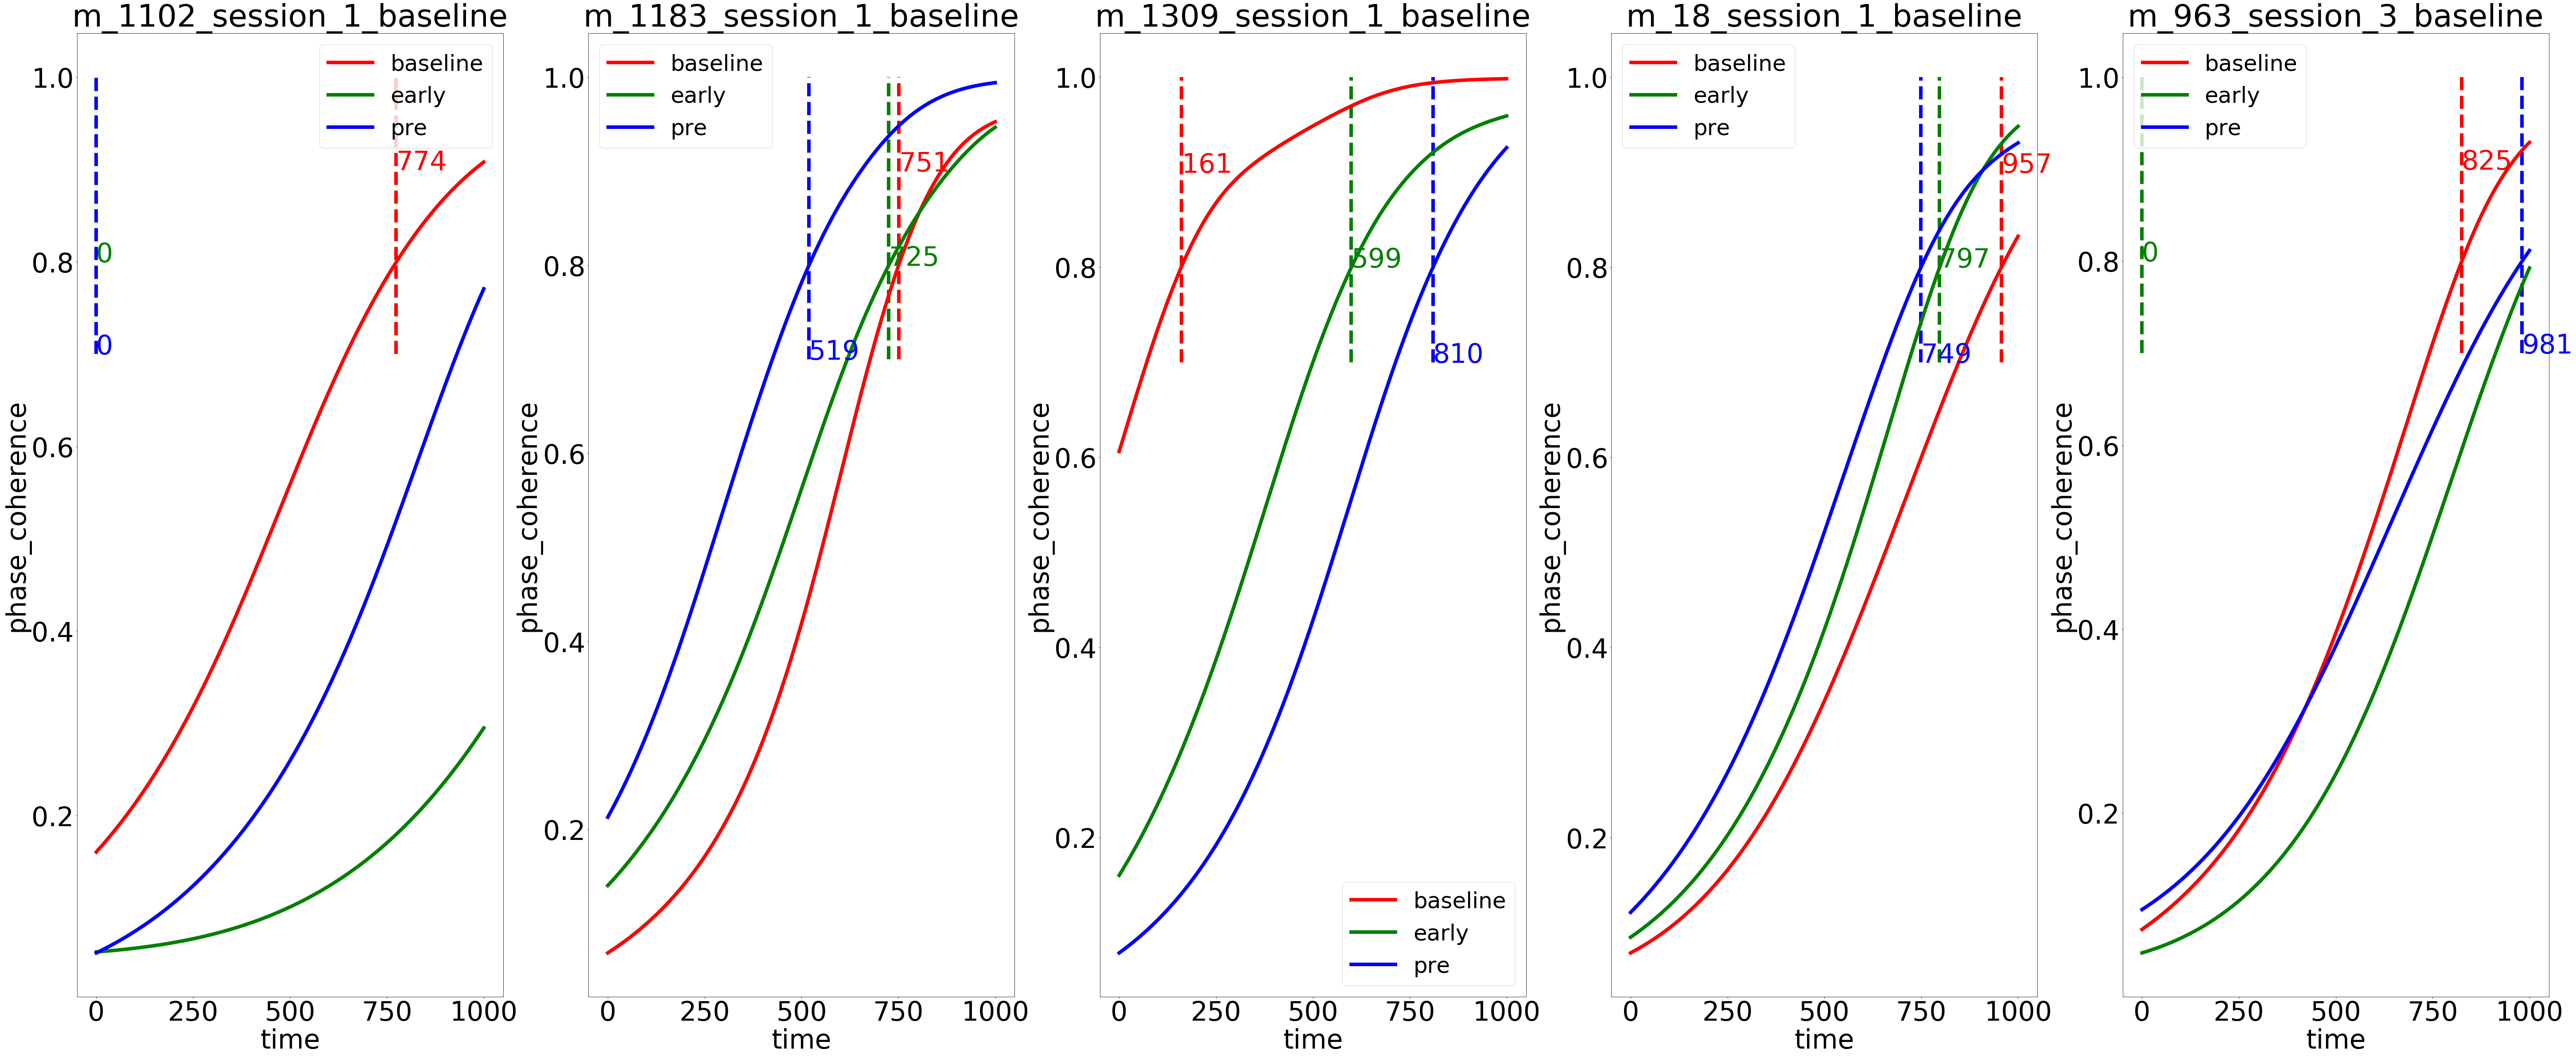

In [11]:
n = int(len(test_names)/3)
fig,ax = plt.subplots(1,n,figsize=(100,40))
x = np.linspace(0,iteration,iteration)
for i in range(n):
        ax[i].plot(x,phase_coherences['%s'%test_names[i*3]],linewidth=8,c='r',label='baseline')
        ax[i].plot(x,phase_coherences['%s'%test_names[i*3+1]],linewidth=8,c='g',label='early')
        ax[i].plot(x,phase_coherences['%s'%test_names[i*3+2]],linewidth=8,c='b',label='pre')
        ax[i].set_title('%s'%test_names[i*3],fontsize=70)
        ax[i].set_ylabel('phase_coherence',fontsize=60)
        ax[i].set_xlabel('time',fontsize=60)
        ax[i].tick_params(axis='both', which='major', labelsize=60)
        ax[i].vlines(thresholds[i*3],0.7,1,color='r',linewidth=8,linestyles='dashed')
        ax[i].vlines(thresholds[i*3+1],0.7,1,color='g',linewidth=8,linestyles='dashed')
        ax[i].vlines(thresholds[i*3+2],0.7,1,color='b',linewidth=8,linestyles='dashed')
        ax[i].text(thresholds[i*3], 0.9 ,'%s'%thresholds[i*3], fontsize=60, c='r')
        ax[i].text(thresholds[i*3+1], 0.8 ,'%s'%thresholds[i*3+1], fontsize=60, c='g')
        ax[i].text(thresholds[i*3+2], 0.7 ,'%s'%thresholds[i*3+2], fontsize=60, c='b')
        ax[i].legend(fontsize=50)

## 8) Initialize networks and oscillators, feel free to play with the variables:
##   -omega='uniform'
##   -network type='configuration'

### 8a)You can change the coupling strehgth $\lambda$=[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6],

In [31]:
#lanbda=[0.1+0.05*k for k in range(10)]

#time_lanbda_phase_osc = []
#time_lanbda_phase_net = []
#time_lanbda_phase_kur_net = []

#for m,l in enumerate(lanbda):
    
    #oscillators = {}
    #networks = {}
    #kuramoto_networks = {}
    
    #for i, name in enumerate(test_names):
        
        #O = []
        
        #for j in range(len(initial_state[name])):
            #O.append(kuramoto_oscillator('uniform',initial_state[name][j],l*alpha[name][j]))## oscillators with omega=1, state=average calcium, coupling strength=edgewise synchrony
        
        #oscillators[name] = O
        
        #N = kuramoto_model_network(0,oscillators[name]).make_network(graph_type='configuration', plot=False, degree_sequence=degree_distributions[name])
        #networks[name] = N
        
        #M = kuramoto_model_network(0,oscillators[name])
        #kuramoto_networks[name] = M
        
    #time_lanbda_phase_osc.append(oscillators)
    #time_lanbda_phase_net.append(networks)
    #time_lanbda_phase_kur_net.append(kuramoto_networks)

### 8b) Iteration=200, takes kinda long, you may want to import the files below

In [45]:
#iteration=200

#rlink__=[]
#averaged_rlink_over_time=[]
#phase_coherences__=[]
#averaged_phase_coherence_over_time=[]
#for m,l in enumerate(lanbda):
    #rlink_ = {}
    #phase_coherences_ = {}
    #for i, name in enumerate(test_names):
        #phase_coherence_over_time = []
        #rlink_over_time = []
        #for t in range(iteration):
            #time_lanbda_phase_kur_net[m][name].update_nodes(time_lanbda_phase_net[m][name],0.01)# running the simulation 1000 times
            #k = time_lanbda_phase_kur_net[m][name].r_of_t(time_lanbda_phase_net[m][name])# computing phase coherence along the way
            #rlink = time_lanbda_phase_kur_net[m][name].r_link_of_t(time_lanbda_phase_net[m][name])[1]
            #phase_coherence_over_time.append(k)
            #rlink_over_time.append(rlink)
        #rlink_[name] = rlink_over_time
        #phase_coherences_[name] = phase_coherence_over_time
        #averaged_rlink_over_time.append(sum([r for r in(rlink_over_time)])/iteration)
        #averaged_phase_coherence_over_time.append(sum([p for p in phase_coherence_over_time])/iteration)
    #rlink__.append(rlink_)
    #phase_coherences__.append(phase_coherences_)

In [12]:
with open('time_lanbda_phase_osc.p', 'rb') as fp:
    time_lanbda_phase_osc = pickle.load(fp)

with open('time_lanbda_phase_net.p', 'rb') as fp:
    time_lanbda_phase_net = pickle.load(fp)
    
with open('time_lanbda_phase_kur_net.p', 'rb') as fp:
    time_lanbda_phase_kur_net = pickle.load(fp)

with open('averaged_phase_coherence_over_time.p', 'rb') as fp:
    averaged_phase_coherence_over_time = pickle.load(fp)
    
with open('averaged_rlink_over_time.p', 'rb') as fp:
    averaged_rlink_over_time = pickle.load(fp)

### 8c) arrange the data into bins for plotting

In [13]:
baseline_phase=[]
baseline_rlink=[]
early_phase=[]
early_rlink=[]
pre_phase=[]
pre_rlink=[]

baseline_phase_scatter=[]
baseline_rlink_scatter=[]
early_phase_scatter=[]
early_rlink_scatter=[]
pre_phase_scatter=[]
pre_rlink_scatter=[]

for i in range(10):
    b_p,e_p,p_p=0,0,0
    b_r,e_r,p_r=0,0,0
    
    b_p_s,e_p_s,p_p_s = [],[],[]
    b_r_s,e_r_s,p_r_s = [],[],[]
    for j in range(5):
        b_p=b_p+averaged_phase_coherence_over_time[i*15+j*3]
        b_r=b_r+averaged_rlink_over_time[i*15+j*3]
        #print(b)
        e_p=e_p+averaged_phase_coherence_over_time[i*15+j*3+1]
        e_r=e_r+averaged_rlink_over_time[i*15+j*3+1]
        #print(e)
        p_p=p_p+averaged_phase_coherence_over_time[i*15+j*3+2]
        p_r=p_r+averaged_rlink_over_time[i*15+j*3+2]
        #print(p)
        
        b_p_s.append(averaged_phase_coherence_over_time[i*15+j*3])
        b_r_s.append(averaged_rlink_over_time[i*15+j*3])
        #print(b)
        e_p_s.append(averaged_phase_coherence_over_time[i*15+j*3+1])
        e_r_s.append(averaged_rlink_over_time[i*15+j*3+1])
        #print(e)
        p_p_s.append(averaged_phase_coherence_over_time[i*15+j*3+2])
        p_r_s.append(averaged_rlink_over_time[i*15+j*3+2])
        #print(p)
        
    b_p=float(b_p/5)
    e_p=float(e_p/5)
    p_p=float(p_p/5)
    b_r=float(b_r/5)
    e_r=float(e_r/5)
    p_r=float(p_r/5)
    baseline_phase.append(float(b_p))
    early_phase.append(float(e_p))
    pre_phase.append(float(p_p))
    baseline_rlink.append(float(b_r))
    early_rlink.append(float(e_r))
    pre_rlink.append(float(p_r))
    
    baseline_phase_scatter.append(b_p_s)
    early_phase_scatter.append(e_p_s)
    pre_phase_scatter.append(p_p_s)
    baseline_rlink_scatter.append(b_r_s)
    early_rlink_scatter.append(e_r_s)
    pre_rlink_scatter.append(p_r_s)

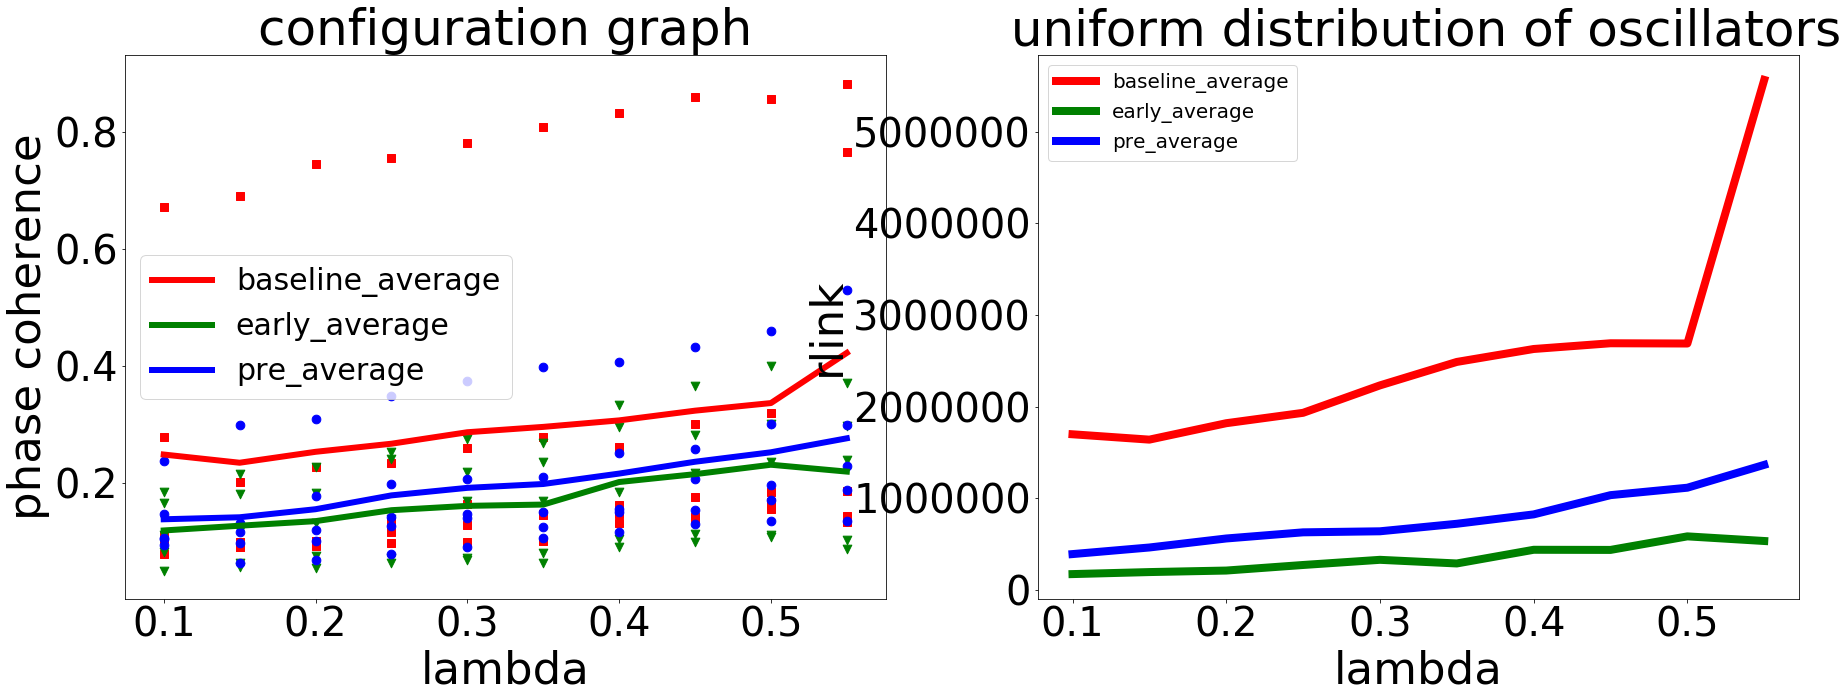

In [14]:
fig,ax=plt.subplots(1,2,figsize=(30,10))
lanbda=[0.1+0.05*k for k in range(10)]
x1=[min(lanbda)]*5
x2=[min(lanbda)/2]*5
x=np.linspace(min(lanbda),max(lanbda),len(lanbda))##
point_1 = np.array(x1)
point_half = np.array(x2)

##phase coherence on ax[0]
ax[0].plot(x, baseline_phase,label='baseline_average', color='r',linewidth=6)
ax[0].plot(x, early_phase, label='early_average',color='g',linewidth=6)
ax[0].plot(x, pre_phase,label='pre_average', color='b',linewidth=6)

for i in range(len(lanbda)):##scattering the individuals
    ax[0].scatter(point_1+point_half*i,baseline_phase_scatter[i], s=75,c='r', marker='s')
    ax[0].scatter(point_1+point_half*i,early_phase_scatter[i], s=75,c='g', marker='v')
    ax[0].scatter(point_1+point_half*i,pre_phase_scatter[i], s=75,c='b', marker='o')

ax[0].set_title('configuration graph',fontsize=50)
ax[0].set_xlabel('lambda',fontsize=45)
ax[0].set_ylabel('phase coherence',fontsize=45)
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[0].legend(fontsize=30)

##rlink on ax[1]
ax[1].plot(x, baseline_rlink,label='baseline_average', color='r',linewidth=8)
ax[1].plot(x, early_rlink, label='early_average',color='g',linewidth=8)
ax[1].plot(x, pre_rlink,label='pre_average', color='b',linewidth=8)
ax[1].set_title(' uniform distribution of oscillators',fontsize=50)

ax[1].set_xlabel('lambda',fontsize=45)
ax[1].set_ylabel('rlink',fontsize=45)
ax[1].tick_params(axis='both', which='major', labelsize=40)
ax[1].legend(fontsize=20)